# ETDRK from the Ground Up

This tutorial explains **Fourier pseudo-spectral Exponential Time Differencing
Runge-Kutta (ETDRK) methods** from first principles. These methods are the
backbone of every timestepper in `Exponax`. We will build up from scalar ODEs
to spectral methods, implement ETDRK0 through ETDRK4, discuss dealiasing, and
extend to higher spatial dimensions.

**Outline:**

1. Linear ODEs and the matrix exponential
2. Spectral derivatives (turning a PDE into decoupled ODEs)
3. ETDRK0 — exact integration of linear PDEs
4. Semi-linear PDEs and ETDRK1/2
5. The contour integral trick for numerically stable coefficients
6. Convergence comparison of ETDRK orders
7. Dealiasing (Orszag's 2/3 rule)
8. Higher dimensions and limitations

**Key references:**

- Cox & Matthews (2002), *Exponential Time Differencing for Stiff Systems*,
  J. Comput. Phys. 176.
- Kassam & Trefethen (2005), *Fourth-Order Time-Stepping for Stiff PDEs*,
  SIAM J. Sci. Comput. 26.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import exponax as ex
from exponax._spectral import (
    build_derivative_operator,
    build_laplace_operator,
    build_wavenumbers,
    low_pass_filter_mask,
)
from exponax.etdrk import ETDRK0, roots_of_unity

jax.config.update("jax_enable_x64", True)

## Linear ODEs and the Matrix Exponential

Consider the scalar ODE

$$ \frac{du}{dt} = \lambda u, \qquad u(0) = u_0. $$

Its exact solution is $u(t) = e^{\lambda t}\, u_0$. A classical explicit Euler
step $u^{n+1} = u^n + \Delta t\, \lambda\, u^n = (1 + \lambda \Delta t)\, u^n$
approximates this, but the **exponential integrator** $u^{n+1} = e^{\lambda
\Delta t}\, u^n$ is *exact* — no time-discretization error at all.

For systems $\frac{d\mathbf{u}}{dt} = A\, \mathbf{u}$, the solution involves
the **matrix exponential**: $\mathbf{u}(t) = e^{At}\, \mathbf{u}_0$. This is
generally $\mathcal{O}(N^3)$ to compute via `expm`. However, when $A$ is
**diagonal**, the matrix exponential reduces to element-wise exponentiation of
the eigenvalues — only $\mathcal{O}(N)$ work. As we will see, Fourier
transforms diagonalize constant-coefficient differential operators, giving us
exactly this structure.

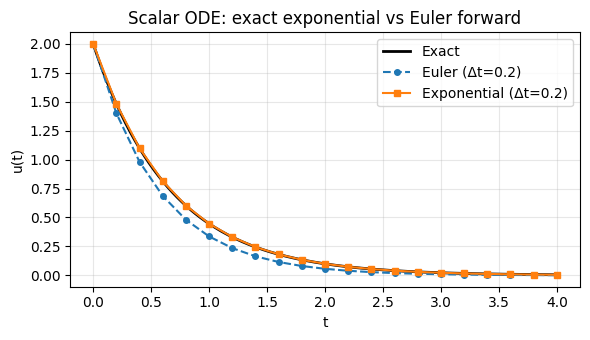

In [ ]:
# Scalar ODE: du/dt = lambda * u, u(0) = u_0
LAMBDA = -1.5
U_0 = 2.0
T_FINAL = 4.0
DT_EULER = 0.2

# Exact solution
t_exact = jnp.linspace(0, T_FINAL, 200)
u_exact = U_0 * jnp.exp(LAMBDA * t_exact)

# Euler forward
n_steps = int(T_FINAL / DT_EULER)
t_euler = jnp.arange(n_steps + 1) * DT_EULER
u_euler = [U_0]
for _ in range(n_steps):
    u_euler.append(u_euler[-1] + DT_EULER * LAMBDA * u_euler[-1])
u_euler = jnp.array(u_euler)

# Exponential integrator (exact for linear ODE)
exp_factor = jnp.exp(LAMBDA * DT_EULER)
u_exp = [U_0]
for _ in range(n_steps):
    u_exp.append(exp_factor * u_exp[-1])
u_exp = jnp.array(u_exp)

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(t_exact, u_exact, "k-", label="Exact", linewidth=2)
ax.plot(t_euler, u_euler, "o--", label=f"Euler (\u0394t={DT_EULER})", markersize=4)
ax.plot(t_euler, u_exp, "s-", label=f"Exponential (\u0394t={DT_EULER})", markersize=4)
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
ax.legend()
ax.set_title("Scalar ODE: exact exponential vs Euler forward")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
# System du/dt = A u with diagonal A
eigenvalues = jnp.array([-0.5, -2.0, -0.1])
A = jnp.diag(eigenvalues)
u0_sys = jnp.array([1.0, 0.5, 2.0])
DT_SYS = 1.0

# Matrix exponential via jax.scipy
exp_A_dt = jax.scipy.linalg.expm(A * DT_SYS)
u1_expm = exp_A_dt @ u0_sys

# For a diagonal matrix, this equals element-wise exp
u1_diag = jnp.exp(eigenvalues * DT_SYS) * u0_sys

print(f"Via expm:              {u1_expm}")
print(f"Via element-wise exp:  {u1_diag}")
print(f"Max difference:        {jnp.max(jnp.abs(u1_expm - u1_diag)):.2e}")

Via expm:              [0.60653066 0.06766764 1.80967484]
Via element-wise exp:  [0.60653066 0.06766764 1.80967484]
Max difference:        1.39e-17


## From PDEs to ODEs: Spectral Derivatives

To solve a PDE numerically, we use the **method of lines**: discretize space
into $N$ degrees of freedom, keeping time continuous. This turns the PDE into
a system of $N$ coupled ODEs.

For **periodic domains** $[0, L)$, the Discrete Fourier Transform (DFT)
diagonalizes constant-coefficient differential operators. A spatial derivative
becomes a pointwise multiplication in Fourier space:

$$ \widehat{\frac{\partial u}{\partial x}} = i k \, \hat{u}_k, \qquad
k = \frac{2\pi}{L} n, \quad n = 0, 1, \dots, N/2. $$

The second derivative (Laplacian in 1D) becomes:

$$ \widehat{\frac{\partial^2 u}{\partial x^2}} = -k^2 \, \hat{u}_k. $$

This turns a linear PDE like $u_t = \nu\, u_{xx}$ into $N/2+1$ **decoupled**
scalar ODEs: $\frac{d\hat{u}_k}{dt} = -\nu k^2 \hat{u}_k$. Each can be
solved exactly with an exponential!

Max error of spectral derivative: 5.33e-14


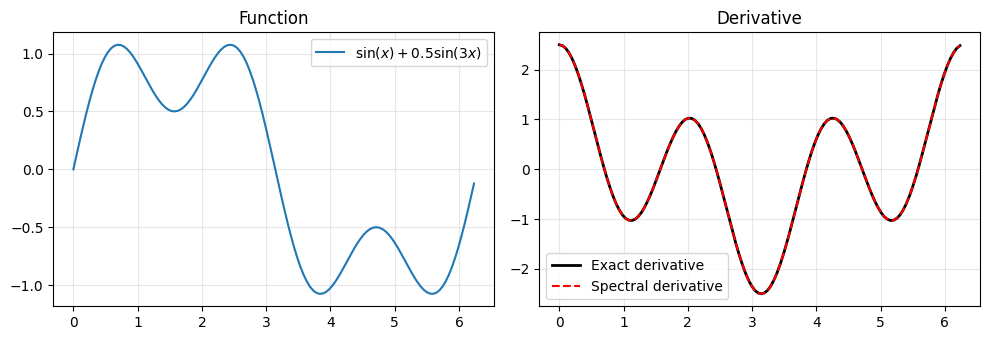

In [4]:
NUM_POINTS = 128
DOMAIN_EXTENT = 2 * jnp.pi

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
x = grid[0]

# Function and its exact derivative
u = jnp.sin(x) + 0.5 * jnp.sin(3 * x)
u_x_exact = jnp.cos(x) + 1.5 * jnp.cos(3 * x)

# Spectral derivative: multiply Fourier coefficients by ik
u_with_channel = u[jnp.newaxis, :]  # shape (1, N)
derivative_op = build_derivative_operator(1, DOMAIN_EXTENT, NUM_POINTS)
u_hat = jnp.fft.rfftn(u_with_channel, axes=(-1,))
u_x_hat = derivative_op * u_hat
u_x_spectral = jnp.fft.irfftn(u_x_hat, s=(NUM_POINTS,), axes=(-1,))[0]

error = jnp.max(jnp.abs(u_x_spectral - u_x_exact))
print(f"Max error of spectral derivative: {error:.2e}")

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
axes[0].plot(x, u, label=r"$\sin(x) + 0.5\sin(3x)$")
axes[0].set_title("Function")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(x, u_x_exact, "k-", label="Exact derivative", linewidth=2)
axes[1].plot(x, u_x_spectral, "r--", label="Spectral derivative")
axes[1].set_title("Derivative")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
wavenumbers = build_wavenumbers(1, NUM_POINTS)
derivative_op = build_derivative_operator(1, DOMAIN_EXTENT, NUM_POINTS)
laplace_op = build_laplace_operator(derivative_op)

print(f"Wavenumbers shape:         {wavenumbers.shape}")
print(f"Derivative operator shape: {derivative_op.shape}")
print(f"Laplace operator shape:    {laplace_op.shape}")
print()
print(f"First 8 wavenumbers:               {wavenumbers[0, :8]}")
print(f"First 8 derivative op (imag part):  {derivative_op[0, :8].imag}")
print(f"First 8 Laplace op (real part):     {laplace_op[0, :8].real}")

Wavenumbers shape:         (1, 65)
Derivative operator shape: (1, 65)
Laplace operator shape:    (1, 65)

First 8 wavenumbers:               [0. 1. 2. 3. 4. 5. 6. 7.]
First 8 derivative op (imag part):  [0. 1. 2. 3. 4. 5. 6. 7.]
First 8 Laplace op (real part):     [  0.  -1.  -4.  -9. -16. -25. -36. -49.]


## ETDRK0: Exact Integration of Linear PDEs

Since the spectral linear operator $\hat{\mathcal{L}}$ is diagonal (one value
per wavenumber), the matrix exponential reduces to an element-wise exponential.
One time step reads:

$$ \hat{u}_k^{[t+1]} = \exp\bigl(\hat{\mathcal{L}}_k \cdot \Delta t\bigr)
\;\hat{u}_k^{[t]}. $$

This is **ETDRK0** — it solves linear PDEs exactly (up to machine precision)
with no time-discretization error, as long as the initial condition is
bandlimited.

**Running example: the heat equation** $u_t = \nu\, u_{xx}$. The linear
operator in Fourier space is $\hat{\mathcal{L}}_k = \nu \cdot (-k^2) = \nu
\cdot \hat{\Delta}_k$, and the analytical solution is
$\hat{u}_k(t) = e^{-\nu k^2 t}\, \hat{u}_k(0)$.

Manual ETDRK0 vs analytical: 2.55e-15
ETDRK0 class  vs analytical: 2.55e-15
Diffusion stp vs analytical: 6.99e-15


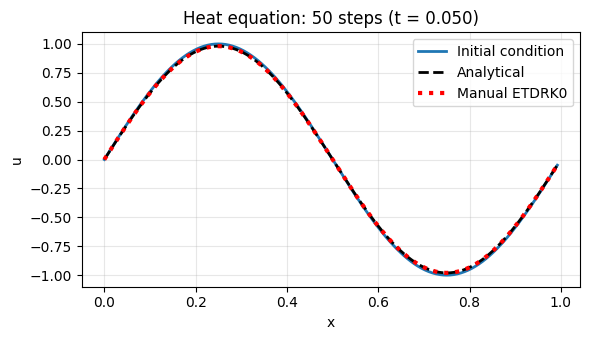

In [6]:
NUM_POINTS = 128
DOMAIN_EXTENT = 1.0
DT = 0.001
NU = 0.01
NUM_STEPS = 50

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
x = grid[0]

# Initial condition: single sine mode
u_0 = jnp.sin(2 * jnp.pi * x / DOMAIN_EXTENT)[jnp.newaxis, :]  # shape (1, N)

# --- Method 1: Manual ETDRK0 ---
derivative_op = build_derivative_operator(1, DOMAIN_EXTENT, NUM_POINTS)
linear_op = NU * build_laplace_operator(derivative_op)  # shape (1, N//2+1)
exp_term = jnp.exp(DT * linear_op)

u_hat = jnp.fft.rfftn(u_0, axes=(-1,))
for _ in range(NUM_STEPS):
    u_hat = exp_term * u_hat
u_manual = jnp.fft.irfftn(u_hat, s=(NUM_POINTS,), axes=(-1,))

# --- Method 2: ETDRK0 class ---
etdrk0 = ETDRK0(DT, linear_op)
u_hat = jnp.fft.rfftn(u_0, axes=(-1,))
for _ in range(NUM_STEPS):
    u_hat = etdrk0.step_fourier(u_hat)
u_etdrk0 = jnp.fft.irfftn(u_hat, s=(NUM_POINTS,), axes=(-1,))

# --- Method 3: Exponax Diffusion stepper ---
diffusion_stepper = ex.stepper.Diffusion(
    1, DOMAIN_EXTENT, NUM_POINTS, DT, diffusivity=NU
)
u_stepper = u_0
for _ in range(NUM_STEPS):
    u_stepper = diffusion_stepper(u_stepper)

# --- Method 4: Analytical solution ---
k = 2 * jnp.pi / DOMAIN_EXTENT
t = NUM_STEPS * DT
u_analytical = (jnp.exp(-NU * k**2 * t) * jnp.sin(2 * jnp.pi * x / DOMAIN_EXTENT))[
    jnp.newaxis, :
]

print(f"Manual ETDRK0 vs analytical: {jnp.max(jnp.abs(u_manual - u_analytical)):.2e}")
print(f"ETDRK0 class  vs analytical: {jnp.max(jnp.abs(u_etdrk0 - u_analytical)):.2e}")
print(f"Diffusion stp vs analytical: {jnp.max(jnp.abs(u_stepper - u_analytical)):.2e}")

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(x, u_0[0], label="Initial condition", linewidth=2)
ax.plot(x, u_analytical[0], "k--", label="Analytical", linewidth=2)
ax.plot(x, u_manual[0], "r:", label="Manual ETDRK0", linewidth=3)
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.legend()
ax.set_title(f"Heat equation: {NUM_STEPS} steps (t = {t:.3f})")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Semi-Linear PDEs: The ETDRK Approach

Many interesting PDEs have both a linear and a nonlinear part:

$$ u_t = \underbrace{\mathcal{L}\, u}_{\text{linear}} +
\underbrace{\mathcal{N}(u)}_{\text{nonlinear}}. $$

**Example: Burgers equation** (conservative form)

$$ u_t + \tfrac{1}{2}(u^2)_x = \nu\, u_{xx} $$

Here $\mathcal{L} = \nu\, \partial_{xx}$ (diffusion) and
$\mathcal{N}(u) = -\tfrac{1}{2}(u^2)_x$ (nonlinear advection).

The **variation-of-constants** formula integrates the linear part exactly and
leaves an integral over the nonlinear forcing:

$$ \hat{u}_k(t + \Delta t) = e^{\hat{\mathcal{L}}_k \Delta t}\,
\hat{u}_k(t) + \int_0^{\Delta t} e^{\hat{\mathcal{L}}_k(\Delta t - \tau)}\,
\hat{\mathcal{N}}_k\bigl(u(t+\tau)\bigr)\, d\tau. $$

**ETDRK1** approximates this integral with a rectangle rule, replacing
$\hat{\mathcal{N}}_k$ by its value at $t$. This yields the coefficient
$\varphi_1(z) = (e^z - 1)/z$ where $z = \hat{\mathcal{L}}_k \Delta t$:

$$ \hat{u}_k^{[t+1]} = e^{\hat{\mathcal{L}}_k \Delta t}\, \hat{u}_k^{[t]}
+ \Delta t\, \varphi_1(\hat{\mathcal{L}}_k \Delta t) \;
\hat{\mathcal{N}}_k(\hat{u}^{[t]}). $$

**ETDRK2** adds a corrector stage for second-order accuracy.

The nonlinear term is evaluated **pseudo-spectrally**: dealias $\to$ IFFT
$\to$ compute $u^2$ pointwise $\to$ FFT $\to$ multiply by $ik$.

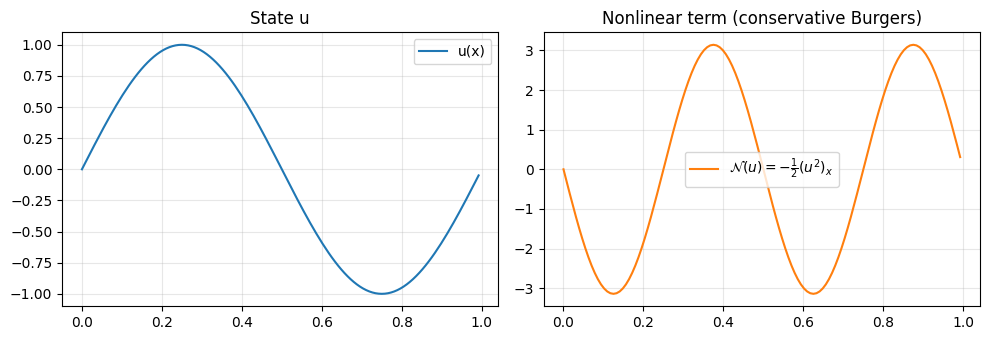

In [7]:
NUM_POINTS = 128
DOMAIN_EXTENT = 1.0
NU = 0.02
CONVECTION_SCALE = 1.0

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
x = grid[0]

# Smooth initial condition
u_0 = jnp.sin(2 * jnp.pi * x / DOMAIN_EXTENT)[jnp.newaxis, :]  # shape (1, N)

# Build operators
derivative_op = build_derivative_operator(1, DOMAIN_EXTENT, NUM_POINTS)
sum_derivative_op = jnp.sum(derivative_op, axis=0, keepdims=True)  # shape (1, N//2+1)

# Dealiasing mask (Orszag's 2/3 rule) — matches BaseNonlinearFun
nyquist_mode = NUM_POINTS // 2 + 1
highest_resolved = nyquist_mode - 1
cutoff = 2 / 3 * highest_resolved - 1
dealiasing_mask = low_pass_filter_mask(1, NUM_POINTS, cutoff=cutoff)

# Pseudo-spectral evaluation of N(u) = -1/2 * convection_scale * (u^2)_x
u_hat = jnp.fft.rfftn(u_0, axes=(-1,))
u_hat_dealiased = dealiasing_mask * u_hat
u_phys = jnp.fft.irfftn(u_hat_dealiased, s=(NUM_POINTS,), axes=(-1,))
u_squared_hat = jnp.fft.rfftn(u_phys**2, axes=(-1,))
N_hat = -CONVECTION_SCALE * 0.5 * sum_derivative_op * u_squared_hat

# Transform back to physical space for visualization
N_physical = jnp.fft.irfftn(N_hat, s=(NUM_POINTS,), axes=(-1,))

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
axes[0].plot(x, u_0[0], label="u(x)")
axes[0].set_title("State u")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(
    x,
    N_physical[0],
    color="tab:orange",
    label=r"$\mathcal{N}(u) = -\frac{1}{2}(u^2)_x$",
)
axes[1].set_title("Nonlinear term (conservative Burgers)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Manual ETDRK1 vs Exponax Burgers: 0.00e+00


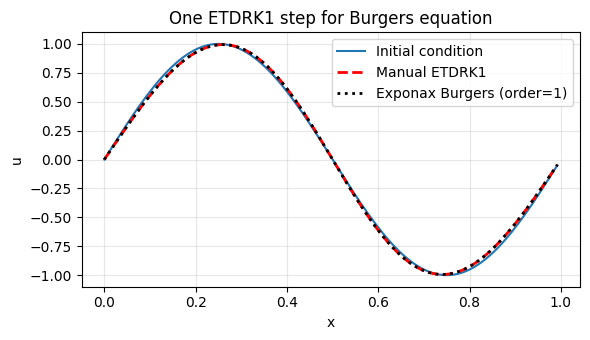

In [8]:
DT = 0.01

# Build linear operator (diffusion)
linear_op = NU * build_laplace_operator(derivative_op)

# Compute ETDRK1 coefficients via contour integral
NUM_CIRCLE_POINTS = 16
CIRCLE_RADIUS = 1.0
roots = roots_of_unity(NUM_CIRCLE_POINTS)
LR = CIRCLE_RADIUS * roots + linear_op[..., jnp.newaxis] * DT  # (..., N//2+1, M)
exp_term = jnp.exp(DT * linear_op)
coef_1 = DT * jnp.mean((jnp.exp(LR) - 1) / LR, axis=-1).real

# Nonlinear term at current state
u_hat = jnp.fft.rfftn(u_0, axes=(-1,))
u_hat_dealiased = dealiasing_mask * u_hat
u_phys = jnp.fft.irfftn(u_hat_dealiased, s=(NUM_POINTS,), axes=(-1,))
u_sq_hat = jnp.fft.rfftn(u_phys**2, axes=(-1,))
N_hat = -CONVECTION_SCALE * 0.5 * sum_derivative_op * u_sq_hat

# ETDRK1 step: u_next = exp_term * u_hat + coef_1 * N_hat
u_next_hat = exp_term * u_hat + coef_1 * N_hat
u_next_manual = jnp.fft.irfftn(u_next_hat, s=(NUM_POINTS,), axes=(-1,))

# Compare with Exponax Burgers stepper (order=1, conservative=True)
burgers_stepper = ex.stepper.Burgers(
    1,
    DOMAIN_EXTENT,
    NUM_POINTS,
    DT,
    diffusivity=NU,
    convection_scale=CONVECTION_SCALE,
    order=1,
    conservative=True,
)
u_next_exponax = burgers_stepper(u_0)

error = jnp.max(jnp.abs(u_next_manual - u_next_exponax))
print(f"Manual ETDRK1 vs Exponax Burgers: {error:.2e}")

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(x, u_0[0], label="Initial condition")
ax.plot(x, u_next_manual[0], "r--", label="Manual ETDRK1", linewidth=2)
ax.plot(x, u_next_exponax[0], "k:", label="Exponax Burgers (order=1)", linewidth=2)
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.legend()
ax.set_title("One ETDRK1 step for Burgers equation")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Numerically Stable Coefficients: The Contour Integral Trick

The ETDRK1 coefficient $\varphi_1(z) = (e^z - 1)/z$ has a **removable
singularity** at $z = 0$ (the limit is 1). However, naive floating-point
evaluation suffers from catastrophic cancellation near $z = 0$: the numerator
$e^z - 1 \approx 0$ and the denominator $z \approx 0$, producing `nan`.

**Kassam & Trefethen (2005)** proposed using **Cauchy's integral formula**:
evaluate $\varphi_1$ on a circle of radius $r$ centered at each
$z_k = \hat{\mathcal{L}}_k \Delta t$ in the complex plane, then average
over $M$ equispaced points:

$$ \varphi_1(z_k) \approx \frac{1}{M} \sum_{m=1}^{M}
\frac{e^{z_k + r\, \omega_m} - 1}{z_k + r\, \omega_m}, $$

where $\omega_m$ are the $M$-th roots of unity. The key insight is that the
evaluation points $z_k + r\, \omega_m$ are *never* exactly zero (they sit on
a circle around $z_k$), so no cancellation occurs.

Exponax uses $M = 16$ and $r = 1.0$ by default.

           z                 naive               contour
--------------------------------------------------------


     1.0e+00     1.718281828459046     1.718281828459038
     1.0e-01     1.051709180756477     1.051709180756473
     1.0e-02     1.005016708416795     1.005016708416803
     1.0e-04     1.000050001667141     1.000050001666706
     1.0e-08     0.999999993922529     1.000000004999997
     1.0e-15     1.110223024625157     0.999999999999998
     0.0e+00                   nan     0.999999999999997
    -1.0e+00     0.632120558828558     0.632120558828557
    -1.0e-02     0.995016625083189     0.995016625083192


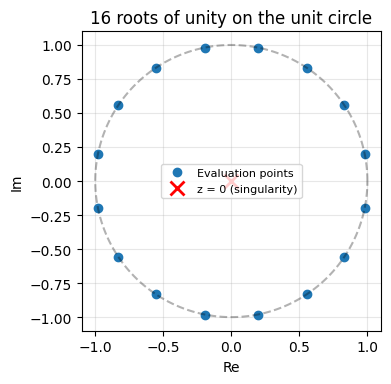

In [9]:
# Compare naive vs contour evaluation of phi_1(z) = (exp(z) - 1) / z


def phi_1_naive(z):
    return (jnp.exp(z) - 1) / z


def phi_1_contour(z, M=16, r=1.0):
    """Evaluate phi_1 using contour integral with M points."""
    w = roots_of_unity(M)
    zr = z + r * w
    return jnp.mean((jnp.exp(zr) - 1) / zr).real


test_z = [1.0, 0.1, 0.01, 1e-4, 1e-8, 1e-15, 0.0, -1.0, -0.01]

print(f"{'z':>12s}  {'naive':>20s}  {'contour':>20s}")
print("-" * 56)
for z_val in test_z:
    naive_val = float(phi_1_naive(z_val))
    contour_val = float(phi_1_contour(z_val))
    print(f"{z_val:12.1e}  {naive_val:20.15f}  {contour_val:20.15f}")

# Visualize the 16 roots of unity
fig, ax = plt.subplots(figsize=(4, 4))
M = 16
w = roots_of_unity(M)
ax.plot(jnp.real(w), jnp.imag(w), "o", markersize=6, label="Evaluation points")
theta = jnp.linspace(0, 2 * jnp.pi, 200)
ax.plot(jnp.cos(theta), jnp.sin(theta), "k--", alpha=0.3)
ax.plot(0, 0, "rx", markersize=10, markeredgewidth=2, label="z = 0 (singularity)")
ax.set_aspect("equal")
ax.set_xlabel("Re")
ax.set_ylabel("Im")
ax.set_title(f"{M} roots of unity on the unit circle")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## ETDRK Orders 0--4: Convergence Comparison

The ETDRK family provides methods of different temporal orders. Each higher
order requires more nonlinear function evaluations per step but achieves
higher accuracy:

| Method  | Nonlinear evals/step | Temporal order | Notes |
|---------|---------------------|----------------|-------|
| ETDRK0  | 0                   | exact (linear) | Linear PDEs only |
| ETDRK1  | 1                   | 1              | Rectangle rule |
| ETDRK2  | 2                   | 2              | Predictor-corrector, **Exponax default** |
| ETDRK4  | 4                   | 4              | RK4-like with half-steps |

ETDRK2 (the default in Exponax) is a good compromise for single precision.
For highest accuracy, use ETDRK4 with double precision
(`jax_enable_x64=True`).

Below we compare all four on Burgers equation — first qualitatively
(space-time plots), then quantitatively (convergence rates).

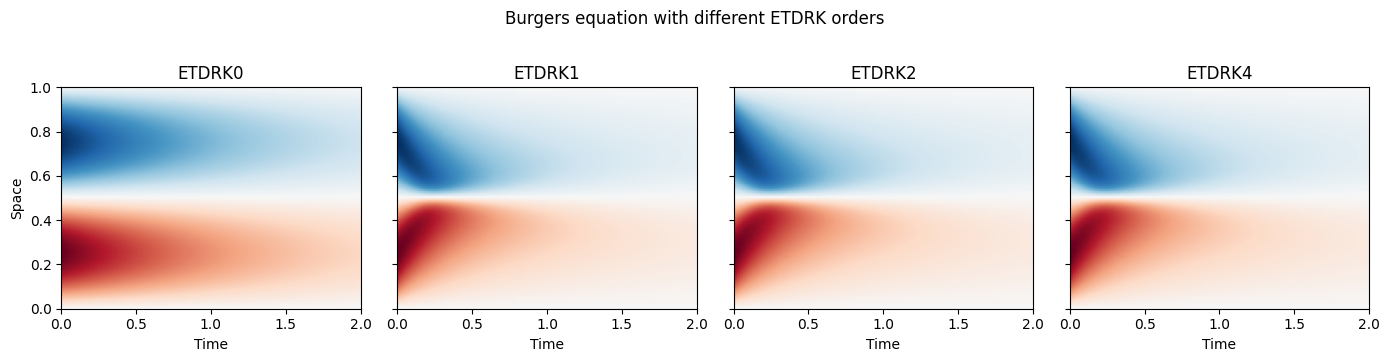

In [10]:
NUM_POINTS = 128
DOMAIN_EXTENT = 1.0
DT = 0.01
NU = 0.02
NUM_STEPS = 200

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
x = grid[0]
u_0 = jnp.sin(2 * jnp.pi * x / DOMAIN_EXTENT)[jnp.newaxis, :]

fig, axes = plt.subplots(1, 4, figsize=(14, 3.5), sharey=True)

for i, (order, title) in enumerate(
    [(0, "ETDRK0"), (1, "ETDRK1"), (2, "ETDRK2"), (4, "ETDRK4")]
):
    stepper = ex.stepper.Burgers(
        1,
        DOMAIN_EXTENT,
        NUM_POINTS,
        DT,
        diffusivity=NU,
        order=order,
        conservative=True,
    )
    rollout_fn = ex.rollout(stepper, NUM_STEPS, include_init=True)
    trajectory = rollout_fn(u_0)

    axes[i].imshow(
        trajectory[:, 0, :].T,
        aspect="auto",
        origin="lower",
        cmap="RdBu_r",
        vmin=-1,
        vmax=1,
        extent=[0, NUM_STEPS * DT, 0, DOMAIN_EXTENT],
    )
    axes[i].set_title(title)
    axes[i].set_xlabel("Time")
    if i == 0:
        axes[i].set_ylabel("Space")

plt.suptitle("Burgers equation with different ETDRK orders", y=1.02)
plt.tight_layout()
plt.show()

ETDRK1: slopes = ['2.35', '1.24', '1.08', '1.04']


ETDRK2: slopes = ['1.98', '1.97', '2.00', '2.00']


ETDRK4: slopes = ['3.65', '3.69', '3.74', '3.85']


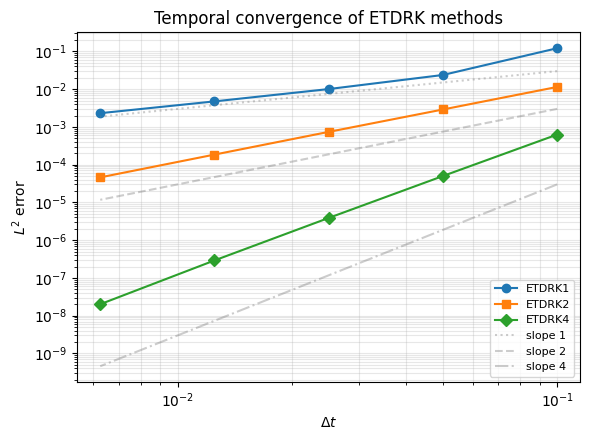

In [11]:
# Temporal convergence test
NUM_POINTS = 256
DOMAIN_EXTENT = 1.0
NU = 0.02
T_FINAL = 0.5

grid = ex.make_grid(1, DOMAIN_EXTENT, NUM_POINTS)
x = grid[0]
u_0 = jnp.sin(2 * jnp.pi * x / DOMAIN_EXTENT)[jnp.newaxis, :]

# Reference solution: ETDRK4 with very small dt
DT_REF = 1e-4
n_ref = int(T_FINAL / DT_REF)
ref_stepper = ex.stepper.Burgers(
    1,
    DOMAIN_EXTENT,
    NUM_POINTS,
    DT_REF,
    diffusivity=NU,
    order=4,
    conservative=True,
)
u_ref = ex.repeat(ref_stepper, n_ref)(u_0)

# Test various dt values
dt_values = [0.1, 0.05, 0.025, 0.0125, 0.00625]

fig, ax = plt.subplots(figsize=(6, 4.5))

for order, label, marker in [
    (1, "ETDRK1", "o"),
    (2, "ETDRK2", "s"),
    (4, "ETDRK4", "D"),
]:
    errors = []
    for dt in dt_values:
        n_steps = int(T_FINAL / dt)
        stepper = ex.stepper.Burgers(
            1,
            DOMAIN_EXTENT,
            NUM_POINTS,
            dt,
            diffusivity=NU,
            order=order,
            conservative=True,
        )
        u_final = ex.repeat(stepper, n_steps)(u_0)
        l2_err = float(jnp.sqrt(jnp.mean((u_final - u_ref) ** 2)))
        errors.append(l2_err)

    ax.loglog(dt_values, errors, f"{marker}-", label=label, markersize=6)

    # Print measured slopes
    log_dt = jnp.log(jnp.array(dt_values))
    log_err = jnp.log(jnp.array(errors))
    slopes = jnp.diff(log_err) / jnp.diff(log_dt)
    print(f"{label}: slopes = {[f'{s:.2f}' for s in slopes]}")

# Reference slope triangles
dt_arr = jnp.array(dt_values)
for slope, ls in [(1, ":"), (2, "--"), (4, "-.")]:
    # Anchor at the midpoint of the dt range
    anchor_dt = dt_arr[2]
    anchor_err = float(anchor_dt) ** slope * 0.3
    ref_line = anchor_err * (dt_arr / anchor_dt) ** slope
    ax.loglog(dt_arr, ref_line, "gray", ls=ls, alpha=0.4, label=f"slope {slope}")

ax.set_xlabel(r"$\Delta t$")
ax.set_ylabel(r"$L^2$ error")
ax.set_title("Temporal convergence of ETDRK methods")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()

## Dealiasing: Orszag's 2/3 Rule

When we evaluate a **quadratic** nonlinearity like $u^2$ pseudo-spectrally,
multiplying two signals in physical space corresponds to convolving their
Fourier coefficients. If modes $k_1$ and $k_2$ are both populated, the product
creates energy at $k_1 + k_2$. When $k_1 + k_2$ exceeds the Nyquist
frequency $N/2$, this energy is **aliased** back into the resolved range,
creating spurious content.

**Orszag's 2/3 rule**: before evaluating the nonlinearity, zero out the
top 1/3 of Fourier modes. Then the maximum sum
$k_1 + k_2 \le 2 \cdot \tfrac{2}{3} \cdot \tfrac{N}{2}
= \tfrac{2N}{3}$ stays below $N/2 + N/3 = \tfrac{5N}{6}$,
meaning any aliases only land in the already-zeroed modes and will be
removed at the next dealiasing step.

In Exponax, the `dealiasing_fraction=2/3` parameter controls this.

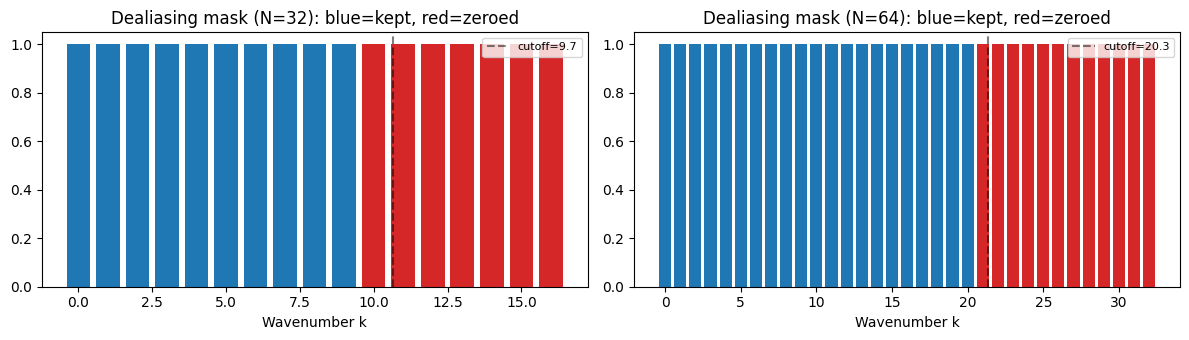

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))

for ax, N in zip(axes, [32, 64], strict=False):
    wn = build_wavenumbers(1, N)[0]  # shape (N//2+1,)
    # Match the cutoff computation from BaseNonlinearFun
    nyquist = N // 2 + 1
    highest = nyquist - 1
    cutoff = 2 / 3 * highest - 1
    mask = low_pass_filter_mask(1, N, cutoff=cutoff)[0]  # shape (N//2+1,)

    colors = ["tab:blue" if m else "tab:red" for m in mask]
    ax.bar(wn, jnp.ones_like(wn), color=colors, width=0.8)
    ax.set_xlabel("Wavenumber k")
    ax.set_title(f"Dealiasing mask (N={N}): blue=kept, red=zeroed")
    ax.axvline(
        x=float(cutoff + 1),
        color="k",
        linestyle="--",
        alpha=0.5,
        label=f"cutoff={cutoff:.1f}",
    )
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## Higher Dimensions

The Fourier basis naturally extends to higher dimensions via tensor products.
In 2D, the derivative operator has shape `(D, N, N//2+1)` and the Laplacian
sums over spatial dimensions:

$$ \hat{\Delta}_\mathbf{k} = \sum_{d=1}^{D} (i k_d)^2 = -|\mathbf{k}|^2. $$

Everything — ETDRK coefficients, dealiasing masks, the exponential term — is
computed element-wise per wavenumber vector, so the generalization is
straightforward.

/tmp/ipykernel_1060111/3804100045.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


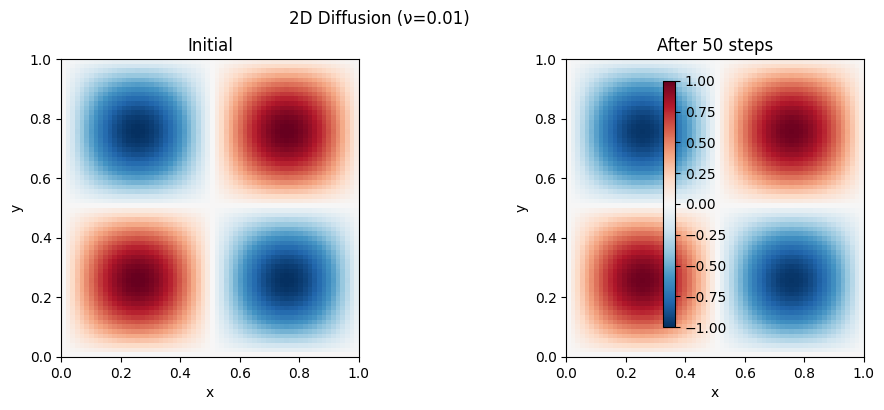

In [13]:
NUM_POINTS_2D = 64
DOMAIN_EXTENT_2D = 1.0
DT_2D = 0.0005
NU_2D = 0.01
NUM_STEPS_2D = 50

grid_2d = ex.make_grid(2, DOMAIN_EXTENT_2D, NUM_POINTS_2D)

# Sinusoidal IC: sin(2*pi*x) * sin(2*pi*y)
u_0_2d = jnp.sin(2 * jnp.pi * grid_2d[0:1] / DOMAIN_EXTENT_2D) * jnp.sin(
    2 * jnp.pi * grid_2d[1:2] / DOMAIN_EXTENT_2D
)

diffusion_2d = ex.stepper.Diffusion(
    2,
    DOMAIN_EXTENT_2D,
    NUM_POINTS_2D,
    DT_2D,
    diffusivity=NU_2D,
)
u_final_2d = ex.repeat(diffusion_2d, NUM_STEPS_2D)(u_0_2d)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (u, title) in zip(
    axes,
    [(u_0_2d, "Initial"), (u_final_2d, f"After {NUM_STEPS_2D} steps")],
    strict=False,
):
    im = ax.imshow(
        u[0].T,
        origin="lower",
        cmap="RdBu_r",
        vmin=-1,
        vmax=1,
        extent=[0, DOMAIN_EXTENT_2D, 0, DOMAIN_EXTENT_2D],
    )
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
plt.colorbar(im, ax=axes, shrink=0.8)
plt.suptitle(f"2D Diffusion (\u03bd={NU_2D})")
plt.tight_layout()
plt.show()

## Limitations

**Theoretical limitations of Fourier pseudo-spectral ETDRK:**

1. **Periodic boundary conditions only** — the DFT assumes periodicity.
2. **No channel mixing in the linear operator** — $\hat{\mathcal{L}}$ acts
   independently per channel (no coupled systems like the wave equation in
   first-order form).
3. **First-order in time** — the PDE must be of the form $u_t = \dots$
   (no $u_{tt}$).
4. **Smooth solutions required** — Fourier methods produce Gibbs ringing near
   discontinuities. Solutions must remain sufficiently smooth.
5. **CFL-like constraint on the nonlinear part** — while the linear part is
   integrated exactly, the nonlinear term is treated explicitly, imposing a
   practical time-step limit.
6. **Cartesian domains only** — the uniform grid and FFT require
   rectangular/cuboid domains.

**Exponax-specific limitations:**

1. Same domain extent in every spatial dimension (scaled hypercube).
2. Same number of grid points $N$ in every dimension.
3. Real-valued states only (uses `rfftn`).
4. Constant time step $\Delta t$ (no adaptive stepping).
5. Available orders: 0, 1, 2, 3, 4.

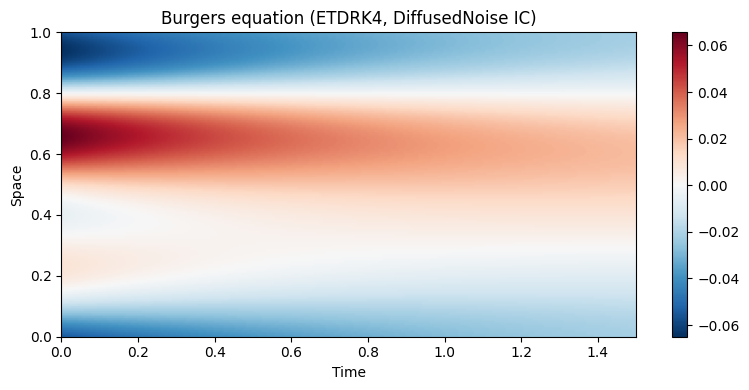

In [14]:
# Full Burgers rollout with random IC
NUM_POINTS = 128
DOMAIN_EXTENT = 1.0
DT = 0.005
NU = 0.01
NUM_STEPS = 300

ic_gen = ex.ic.DiffusedNoise(1, domain_extent=DOMAIN_EXTENT, intensity=0.01)
u_0 = ic_gen(NUM_POINTS, key=jax.random.PRNGKey(42))

burgers = ex.stepper.Burgers(
    1,
    DOMAIN_EXTENT,
    NUM_POINTS,
    DT,
    diffusivity=NU,
    order=4,
    conservative=True,
)
trajectory = ex.rollout(burgers, NUM_STEPS, include_init=True)(u_0)

fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(
    trajectory[:, 0, :].T,
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    extent=[0, NUM_STEPS * DT, 0, DOMAIN_EXTENT],
)
ax.set_xlabel("Time")
ax.set_ylabel("Space")
ax.set_title("Burgers equation (ETDRK4, DiffusedNoise IC)")
plt.colorbar(im)
plt.tight_layout()
plt.show()

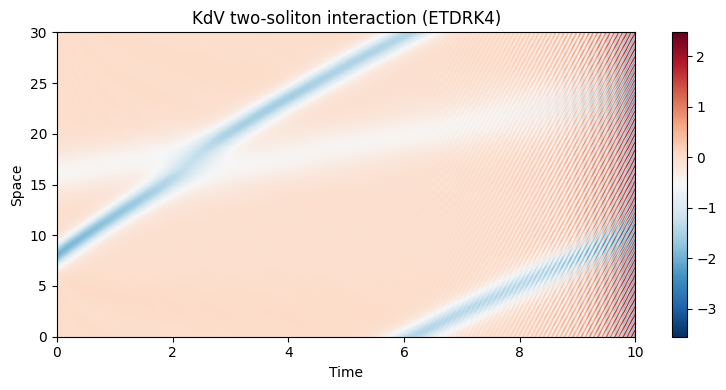

In [15]:
# KdV soliton interaction
DOMAIN_EXTENT_KDV = 30.0
NUM_POINTS_KDV = 256
DT_KDV = 0.01
NUM_STEPS_KDV = 1000

grid_kdv = ex.make_grid(1, DOMAIN_EXTENT_KDV, NUM_POINTS_KDV)
x_kdv = grid_kdv[0]

# Two-soliton IC for KdV with convection_scale=-6:
# u(t,x) = -(c^2/2) sech^2(c/2 * (x - c*t - a))
c1, x1 = 2.0, 8.0  # taller, faster soliton
c2, x2 = 1.0, 16.0  # shorter, slower soliton

soliton_1 = -(c1**2) / 2 / jnp.cosh(c1 / 2 * (x_kdv - x1)) ** 2
soliton_2 = -(c2**2) / 2 / jnp.cosh(c2 / 2 * (x_kdv - x2)) ** 2
u_0_kdv = (soliton_1 + soliton_2)[jnp.newaxis, :]

kdv_stepper = ex.stepper.KortewegDeVries(
    1,
    DOMAIN_EXTENT_KDV,
    NUM_POINTS_KDV,
    DT_KDV,
    convection_scale=-6.0,
    dispersivity=1.0,
    diffusivity=0.0,
    hyper_diffusivity=0.0,
    order=4,
)
trajectory_kdv = ex.rollout(kdv_stepper, NUM_STEPS_KDV, include_init=True)(u_0_kdv)

fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(
    trajectory_kdv[:, 0, :].T,
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    extent=[0, NUM_STEPS_KDV * DT_KDV, 0, DOMAIN_EXTENT_KDV],
)
ax.set_xlabel("Time")
ax.set_ylabel("Space")
ax.set_title("KdV two-soliton interaction (ETDRK4)")
plt.colorbar(im)
plt.tight_layout()
plt.show()